<a href="https://colab.research.google.com/github/mratanusarkar/Learning-DeepLearning/blob/main/Neural%20Networks%20-%20Zero%20to%20Hero/building%20micrograd/08.%20comparison%20-%20micrograd%20vs%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing code from the previous notebook

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
# importing latest Value class

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.label = label  # optional, Value variable/node name
        self.data = data
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children)     # previous node
        self._op = _op                  # the operation that produced this node
        self._backward = lambda: None   # to do the little piece of chain rule at each local node, backwards
                                        # by default _backward is None, as there is nothing to do at a leaf node

    def __repr__(self):
        return f"Value(label={self.label if self.label else 'Null'}, data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # f(x) = x + y, then f'(x) = 1
            # local derivative (= 1.0) * out's grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # f(x) = x * y, then f'(x) = y
            # local derivative (= switching the data of leaf nodes) * out's grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            # f(x) = x^n, then f'(x) = n * x^(n-1)
            # local derivative (= nx^(n-1)) * out's grad
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        ex = math.exp(x)
        out = Value(ex, (self, ), 'exp')

        def _backward():
            # f(x) = exp(x), then f'(x) = exp(x)
            # local derivative of exp (exp(x)) * out's grad
            self.grad += ex * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            # f(x) = ReLU(x) = max(0,x), then f'(x) = {x:1|x>0 and a:0|x<=0}
            # local derivative of ReLU (x > 0) * out's grad
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # f(x) = tanh(x), then f'(x) = 1 - tanh(x)^2
            # local derivative of tanh (1 - tanh(x)**2) * out's grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self): # backpropagation
        # our topological sort function
        def topological_sort(node):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(node)
            return topo

        # base case
        self.grad = 1.0

        # and then traverse backwards, calling _backward() on the way
        for node in reversed(topological_sort(self)):
            node._backward()


In [3]:
# import visualization functions to show grads

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


# let's see the mathematical expression of a neuron using micrograd vs torch

In [4]:
# using micrograd (re-using old code implementation)

In [5]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')    # setting a weird value, as it will help in calculation down the line!

# dendrites of the neuron (inputs weighted)
den1 = x1 * w1;     den1.label='den1'
den2 = x2 * w2;     den2.label='den2'

# sum of dendrite signals inside cell body
sum = den1 + den2;  sum.label='sum'

# bias gets added inside the body
body = sum + b;     body.label='body'

# the net signal passes through an activation function to give output
out = body.tanh();  out.label='out'

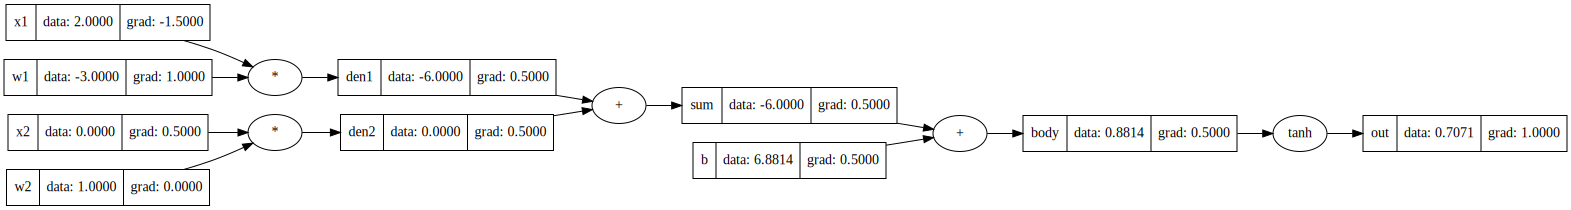

In [6]:
out.backward()
draw_dot(out)

In [7]:
# using PyTorch

In [8]:
# the mathematical expression of a neuron
x1 = torch.Tensor([2.0]).double();                  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b;
o = torch.tanh(n);

# forward pass
print("out:", o.data.item())

# backward pass
o.backward()

# let's print the grads
print("-----")
print("x1 grad:", x1.grad.item())
print("x2 grad:", x2.grad.item())
print("w1 grad:", w1.grad.item())
print("w2 grad:", w2.grad.item())
print("b grad:", b.grad.item())

out: 0.7071066904050358
-----
x1 grad: -1.5000003851533106
x2 grad: 0.5000001283844369
w1 grad: 1.0000002567688737
w2 grad: 0.0
b grad: 0.5000001283844369


In [9]:
print(out)
print(o)

Value(label=out, data=0.7071067811865476, grad=1.0)
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)


In [10]:
print(out.data)
print(o.data)

0.7071067811865476
tensor([0.7071], dtype=torch.float64)


In [11]:
print(body.grad)
print(x1.grad)

0.4999999999999999
tensor([-1.5000], dtype=torch.float64)


In [12]:
# and it matches!! it's the same!

In [13]:
# only difference is as below:
#
# 1. micrograd is a scalar valued engine        | where as in torch everything is based on tensors
# 2. micrograd can handle only simple use-cases | where as torch is built to handle complex situations, millions of data into batches of n-D tensors
# 3. only for scalar data                       | where as torch is for working with actual scenarios, cases and projects
# 4. not optimized and parallelized             | it's more optimized, faster, efficient and supports for both cpu and gpu, and parallelize operations in threads
# 5. we have float64 python default             | torch uses simple precision float32 (hence we used .double to make it float 64)
# 6. Value.data contains the element            | torch wraps data into tensor, so we have to use .item() to pop out the element from the tensor
# 7. simple and built for understanding         | complex and built as a professional, popular ML library and a framework that is used widely

In [14]:
# so basically torch can do what we did in micrograd as a special case where all the tensors are a single element tensors
# otherwise what we have built (thanks to Andrej Karpathy) very much agrees with PyTorch API